In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import torch
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import spacy
from anchor import anchor_text
import pickle
from myUtils import *
import transformerUtils.models as models

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
type_dataset = 'binary' # What kind of dataset to train on trinary, fine_grained or binary

# Preparing the Datasets

In [4]:
import torchtext.data
import torchtext.datasets

In [5]:
def load_dataset(fine_grained = False):
    # torchtext Field objects parse text (e.g. a review) and create a tensor representation

    # This Field object will be used for tokenizing the movie reviews text
    # For this application, tokens ~= words

    review_parser = torchtext.legacy.data.Field(
        sequential=True, use_vocab=True, lower=True, dtype=torch.long,
        tokenize='spacy', tokenizer_language='en_core_web_sm', init_token='sos', eos_token='eos'
    )

    # This Field object converts the text labels into numeric values (0,1,2)
    label_parser = torchtext.legacy.data.Field(
        is_target=True, sequential=False, unk_token=None, use_vocab=True
    )
    
    # Load SST, tokenize the samples and labels
    # ds_X are Dataset objects which will use the parsers to return tensors
    ds_train, ds_valid, ds_test = torchtext.legacy.datasets.SST.splits(
        review_parser, label_parser, root=data_dir, fine_grained=fine_grained
    )


    return review_parser, label_parser, ds_train, ds_valid, ds_test

In [6]:
def build_vocabulary(review_parser, label_parser, ds_train, min_freq):
    review_parser.build_vocab(ds_train, min_freq = min_freq)
    label_parser.build_vocab(ds_train, min_freq= min_freq)

    print(f"Number of tokens in training samples: {len(review_parser.vocab)}")
    print(f"Number of tokens in training labels: {len(label_parser.vocab)}")
    return review_parser, label_parser

In [7]:
def print_dataset(ds, classes, type_ds):
    print(f'Number of {type_ds} samples: {len(ds)}') 
    for class_type in classes:
        number_of_class = len([example for example in ds if example.label == class_type])
        print(f'Number of {class_type} examples {number_of_class}')
    print('------------------------------------------------------')

# Creating Binary Dataset

In [8]:
def filter_neutral(ds):
    ds.examples = [example for example in ds.examples if example.label != 'neutral']

In [9]:
def create_binary_dataset():
    review_parser, label_parser, ds_train, ds_valid, ds_test = load_dataset(fine_grained = False)
    review_parser, label_parser = build_vocabulary(review_parser, label_parser, ds_train, min_freq=5)
    filter_neutral(ds_train)
    filter_neutral(ds_valid)
    filter_neutral(ds_test)
    print_dataset(ds_train, ['positive', 'negative'], 'training')
    print_dataset(ds_valid, ['positive', 'negative'], 'validation')
    print_dataset(ds_test, ['positive', 'negative'], 'test')
    return review_parser, label_parser, ds_train, ds_valid, ds_test

In [10]:
review_parser = None
label_parser = None
ds_train = None
ds_valid = None
ds_test = None

review_parser, label_parser, ds_train, ds_valid, ds_test = create_binary_dataset()

Number of tokens in training samples: 3548
Number of tokens in training labels: 3
Number of training samples: 6920
Number of positive examples 3610
Number of negative examples 3310
------------------------------------------------------
Number of validation samples: 872
Number of positive examples 444
Number of negative examples 428
------------------------------------------------------
Number of test samples: 1821
Number of positive examples 909
Number of negative examples 912
------------------------------------------------------


## Forward Function For Getting Accuracy

In [30]:
import tqdm
def forward_dl(model, dl, device, type_dl):
    model.train(False)
    num_samples = len(dl) * dl.batch_size
    num_batches = len(dl)  
    pbar_name = type(model).__name__
    list_y_real = []
    list_y_pred = []
    pbar_file = sys.stdout
    num_correct = 0
    dl_iter = iter(dl)
    for batch_idx in range(num_batches):
        data = next(dl_iter)
        x, y = data.text, data.label
        list_y_real.append(y)
        x = x.to(device)  # (S, B, E)
        y = y.to(device)  # (B,)
        with torch.no_grad():
            if isinstance(model, models.VanillaGRU):
                y_pred_log_proba = model(x)
            elif isinstance(model, models.MultiHeadAttentionNet):
                y_pred_log_proba, _ = model(x)
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()
            list_y_pred.append(y_pred)
    accuracy = 100.0 * num_correct / num_samples
    print(f'Accuracy for {type_dl} is {accuracy}')
    
    all_y_real = torch.cat(list_y_real)
    all_y_pred = torch.cat(list_y_pred)
    return all_y_real, all_y_pred, accuracy

## Loading Hyper Parameters

In [11]:
import transformerUtils.hyperparams as hyperparams
def load_hyperparams(model_type, type_dataset):
    hp = None
    if model_type == 'gru':
        hp = hyperparams.hyperparams_for_gru_binary()
    elif model_type == 'attention':
        hp = hyperparams.hyperparams_for_attention_binary()
    print(hp)
    return hp

# Load Model

In [12]:
def load_model(model_name, path):
    if model_name == 'gru':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.VanillaGRU(review_parser.vocab, hp['embedding_dim'], hp['hidden_dim'], hp['num_layers'], hp['output_classes'], hp['dropout']).to(device)
    elif model_name == 'attention':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.MultiHeadAttentionNet(input_vocabulary=review_parser.vocab, embed_dim=hp['embedding_dim'], num_heads=hp['num_heads'], 
                                           dropout=hp['dropout'], two_attention_layers=hp['two_atten_layers'], output_classes=hp['output_classes']).to(device)
    saved_state = torch.load(path, map_location=device)
    model.load_state_dict(saved_state["model_state"])
    print(model)
    
    return model

In [13]:
model = load_model('gru' , 'transformerUtils/gru.pt')

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.7, 'lr': 0.0005, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(3548, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.7)
  (dropout_layer): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [14]:
# 1 = pad 2=sos 3 = eof 
def tokenize(text, max_len):
    sentence = review_parser.tokenize(str(text))
    input_tokens = [2] + [review_parser.vocab.stoi[word] for word in sentence] + [3] + [1]*(max_len-len(sentence))

    return input_tokens

In [50]:
def predict_sentences(sentences):
    half_length = len(sentences)//2
    if(half_length>800):
        return np.concatenate([predict_sentences(sentences[:half_length]), predict_sentences(sentences[half_length:])])
    max_len = max([len(sentence) for sentence in sentences])
    sentences = torch.tensor([tokenize(sentence, max_len) for sentence in sentences]).to(device)
    input_tokens = torch.transpose(sentences, 0, 1)
    output = model(input_tokens)
    return torch.argmax(output, dim=1).cpu().numpy().flatten()

# Anchor Part

In [16]:
nlp = spacy.load('en_core_web_sm')

In [17]:
explainer = anchor_text.AnchorText(nlp, ['positive', 'negative'], use_unk_distribution=False)

In [25]:
train, train_labels = [' '.join(example.text) for example in ds_train], [example.label for example in ds_train]
test, test_labels = [' '.join(example.text) for example in ds_train], [example.label for example in ds_train]

In [20]:
anchor_examples = [example for example in train if len(example) < 70 and len(example)>20]

In [21]:
pickle.dump( test, open( "results/transformer_test.pickle", "wb" ))
pickle.dump( test_labels, open( "results/transformer_test_labels.pickle", "wb" ))

In [ ]:
my_utils = TextUtils(anchor_examples, test, explainer, predict_sentences, "results/transformer_exps.pickle")
explanations = my_utils.compute_explanations(list(range(len(anchor_examples))))

In [ ]:
pickle.dump( explanations, open( "results/transformer_exps_list.pickle", "wb" ))

## Training Function

### Saves all the the output in the output directory

In [ ]:
import torch.optim as optim
import training
import plot
import numpy as np
import pandas as pd
from pathlib import Path
def train_model(model_name, device):
    NUM_EPOCHS = 100
    if model_name == 'gru':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.VanillaGRU(review_parser.vocab, hp['embedding_dim'], hp['hidden_dim'], hp['num_layers'], hp['output_classes'], hp['dropout']).to(device)
    elif model_name == 'attention':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.MultiHeadAttentionNet(input_vocabulary=review_parser.vocab, embed_dim=hp['embedding_dim'], num_heads=hp['num_heads'], 
                                           dropout=hp['dropout'], two_attention_layers=hp['two_atten_layers'], output_classes=hp['output_classes']).to(device)
    print(model)
    dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=hp['batch_size'], shuffle=True, device=device)

    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])
    loss_fn = nn.NLLLoss()
    
    trainer = training.SentimentTrainer(model, loss_fn, optimizer, device)
    checkpoint_filename = str(output_directory) +  '/' + model_name
    print(f'Saving checkpoint with prefix: {checkpoint_filename}')
    fit_res = trainer.fit(dl_train, dl_valid, NUM_EPOCHS, early_stopping = hp['early_stopping'], checkpoints = checkpoint_filename, params = hp)

    fig, axes = plot.plot_fit(fit_res)
    fig.savefig(output_directory / str(model_name + '.png'))
    saved_state = torch.load(checkpoint_filename + '.pt', map_location=device)
    model.load_state_dict(saved_state["model_state"])
    loaded_hp = saved_state["parameters"]
    print('----- Loaded params ------')
    print(loaded_hp)
    all_dataloaders = [dl_train, dl_valid, dl_test]
    type_dls = ['train', 'valid', 'test']
    accuracies = []
    for dl, type_dl in zip(all_dataloaders, type_dls):
        y_real, y_pred, accuracy = forward_dl(model, dl, device, type_dl)
        df = compute_confusion_matrix(y_real, y_pred, model_name, type_dl)
        accuracies.append(accuracy)
        display(df)
    numpy_accuracy = np.array(accuracies)
    df = pd.DataFrame(numpy_accuracy, index = type_dls, dtype=float)
    df.to_csv(output_directory / str('accuracies_' + model_name + '.csv')) 

# Training GRU

In [ ]:
SEED = 84
torch.manual_seed(SEED)
#train_model(model_type, device)

# Training Attention

In [ ]:
SEED = 84
torch.manual_seed(SEED)
#train_model('attention', device)

# Loading Results

In [37]:
test = pickle.load( open( "results/transformer_test.pickle", "rb" ))
test_labels = pickle.load( open( "results/transformer_test_labels.pickle", "rb" ))
test = np.array(test)
test_labels = np.array(test_labels)
exps_file  = open( "results/transformer_exps.pickle", "rb" )
num_exps = 500
explanations= []

In [38]:
for _ in range(num_exps):
    explanations.append(pickle.load(exps_file))
exps_file.close()

In [39]:
myUtils =  TextUtils(test, test, None, None, "results/transformer_exps.pickle")
explanations = myUtils.remove_duplicates(explanations)
explanations = [exp for exp in explanations if len(exp.fit_examples) > 10]
explanations.sort(key=lambda exp: exp.precision)

In [56]:
best = explanations[-10:]
best.reverse()
for exp in best:
    print("------------------------")
    exp_label =  predict_sentences([str(test[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % (np.mean(predict_sentences(str(test[exp.fit_examples])) == exp_label)))
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = test_labels[exp.fit_examples]
    real_percentage = np.mean(covered_labels == explainer.class_names[exp_label])
    print('Anchor test REAL precision: %.2f' % real_percentage)

------------------------
Prediction: positive
Anchor: else
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.35
Anchor test coverage: 0.01
Anchor test REAL precision: 0.33
------------------------
Prediction: positive
Anchor: just
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.34
Anchor test coverage: 0.04
Anchor test REAL precision: 0.37
------------------------
Prediction: positive
Anchor: loses
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.35
Anchor test coverage: 0.00
Anchor test REAL precision: 0.21
------------------------
Prediction: negative
Anchor: same
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.63
Anchor test coverage: 0.01
Anchor test REAL precision: 0.62
------------------------
Prediction: negative
Anchor: tries
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.66
Anchor test coverage: 0.00
Anchor test REAL precision: 0.80
------------------------
Prediction: positive
Anchor: possibly
Precision: 1.00
Coverage: 0.00
Anchor test pr

In [61]:
exps = explanations[-len(explanations)//2:]
exps = [exp for exp in exps if len(exp.fit_examples)>0]
real_precisions = [np.mean(test_labels[exp.fit_examples] == explainer.class_names[predict_sentences([str(test[exp.index])])[0]])
                   for exp in exps]
test_precisions = [np.mean(predict_sentences(test[exp.fit_examples]) == predict_sentences([str(test[exp.index])])[0]) 
                   for exp in exps]

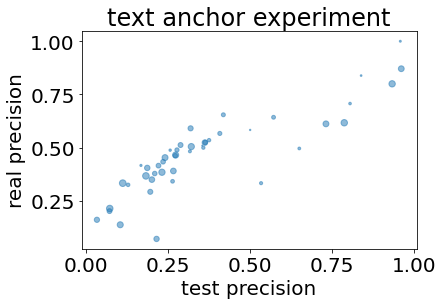

In [62]:
plt.scatter(test_precisions, real_precisions, s = range(len(exps)), alpha = 0.5)
plt.xlabel('test precision')
plt.ylabel('real precision')
plt.title('text anchor experiment')
plt.savefig("results/transformer.png")

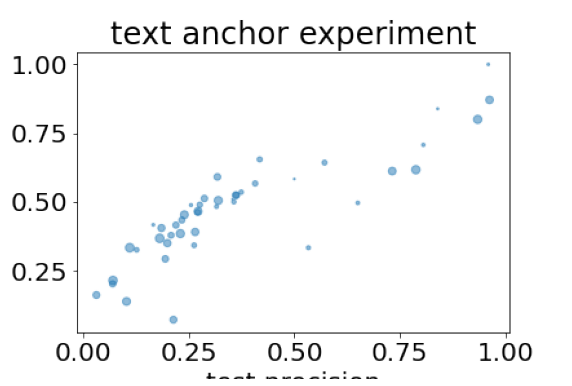

In [63]:
img = plt.imread("results/transformer.png")
plt.figure(figsize = (10,10))
plt.axis('off')
_ = plt.imshow(img)